## Introduction

Let's see what an introductory data analysis and visualization helps us to know about the data

Content:<br>
* [1. Visualization of the recordings - input features](#visualization)
   * [1.1. Wave and spectrogram](#waveandspectrogram)
   * [1.2. MFCC](#mfcc)
   * [1.3. Silence removal](#resampl)
   * [1.4. Resampling - dimensionality reductions](#silenceremoval)
   * [1.5. Features extraction steps](#featuresextractionsteps)
* [2. Dataset investigation](#investigations)
   * [2.1. Number of files](#numberoffiles)
   * [2.3. Length of recordings](#len)

All we need is here:

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
import pandas as pd

%matplotlib inline


# 1. Visualization 
<a id="visualization"></a> 
I see two main tendencies - to input [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) (frequencies), and more sophisticated features MFCC - Mel-Frequency Cepstral Coefficients, PLP. You rarely work with raw, temporal data.

Let's visualize some recordings!

## 1.1. Wave and spectrogram:
<a id="waveandspectrogram"></a> 

Choose and read some file:

In [2]:
train_audio_path = '../data/raw/train/audio'
filename = '/yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

Define a function that calculates spectrogram.

Note, that we are taking logarithm of spectrogram values. It will make our plot much more clear, moreover, it is strictly connected to the way people hear.
We need to assure that there are no 0 values as input to logarithm.

In [3]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Frequencies are in range (0, 8000) according to [Nyquist theorem](https://en.wikipedia.org/wiki/Nyquist_rate).

Let's plot it:

Text(0.5,0,'Seconds')

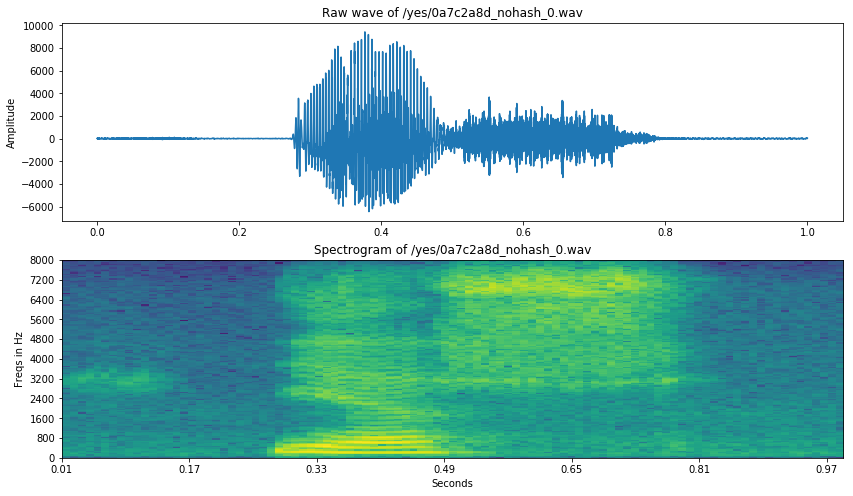

In [4]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

If we use spectrogram as an input features for NN, we have to remember to normalize features. (We need to normalize over all the dataset, here's example just for one, which doesn't give good *mean* and *std*!)

In [5]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

## 1.2. MFCC
<a id="mfcc"></a> 


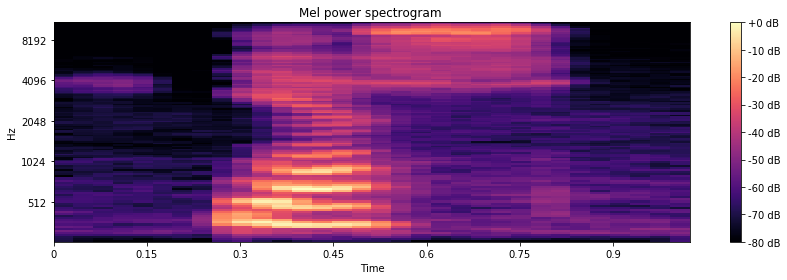

In [6]:
# From this tutorial
# https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

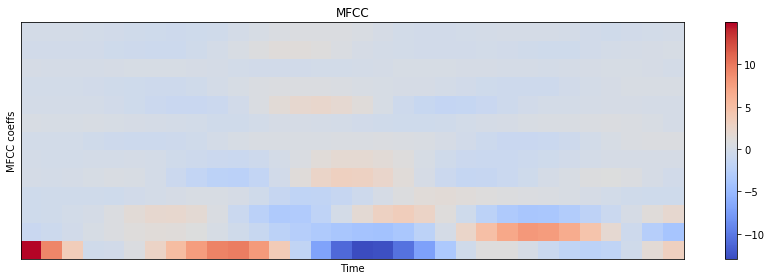

In [7]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In classical, but still state-of-the-art systems, *MFCC*  or similar features are taken as the input to the system instead of spectrograms.

However, in end-to-end (often neural-network based) systems, the most common input features are probably raw spectrograms, or mel power spectrograms. For example *MFCC* decorrelates features, but NNs deal with correlated features well. Also, if you'll understand mel filters.

## 1.3. Silence removal
<a id="silenceremoval"></a> 

Let's listen to that file

In [9]:
ipd.Audio(samples, rate=sample_rate)

Some *VAD* (Voice Activity Detection) will be really useful here. Although the words are short, there is a lot of silence in them. A decent *VAD* can reduce training size a lot, accelerating training speed significantly.
Let's cut a bit of the file from the beginning and from the end. and listen to it again

In [10]:
samples_cut = samples[4000:13000]
ipd.Audio(samples_cut, rate=sample_rate)

*webrtcvad* package to have a good *VAD*.

Let's plot it again, together with guessed alignment of* 'y' 'e' 's'* graphems

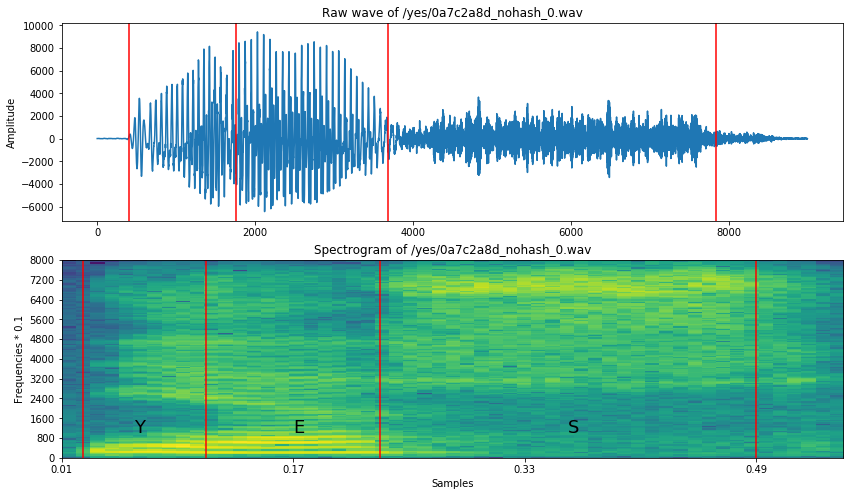

In [11]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

## 1.4. Resampling - dimensionality reduction
<a id="resampl"></a> 

Another way to reduce the dimensionality of our data is to resample recordings.

You can hear that the recording don't sound very natural, because they are sampled with 16k frequency, and we usually hear much more. However, [the most speech related frequencies are presented in smaller band](https://en.wikipedia.org/wiki/Voice_frequency). That's why you can still understand another person talking to the telephone, where GSM signal is sampled to 8000 Hz.

Summarizing, we could resample our dataset to 8k. We will discard some information that shouldn't be important, and we'll reduce size of the data.

We have to remember that it can be risky, because this is a competition, and sometimes very small difference in performance wins, so we don't want to lost anything. On the other hand, first experiments can be done much faster with smaller training size.

We'll need to calculate FFT (Fast Fourier Transform). Definition:


In [12]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

Let's read some recording, resample it, and listen. We can also compare FFT, Notice, that there is almost no information above 4000 Hz in original signal.

In [13]:
filename = '/yes/0a7c2a8d_nohash_0.wav'
new_sample_rate = 8000

sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

In [14]:
ipd.Audio(samples, rate=sample_rate)

In [15]:
ipd.Audio(resampled, rate=new_sample_rate)

Almost no difference!

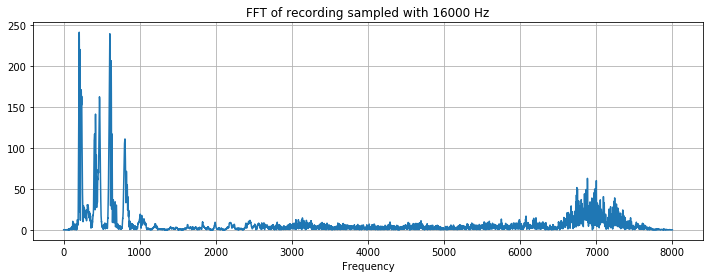

In [16]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

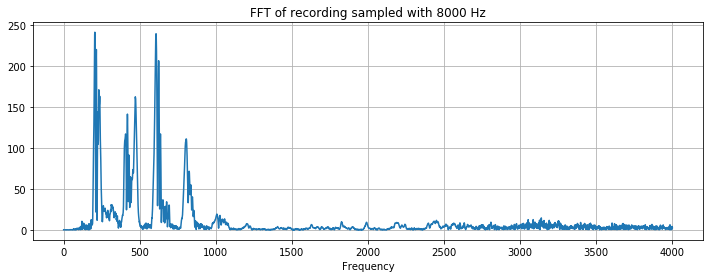

In [17]:
xf, vals = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

This is how we reduced dataset size twice!


# 2. Dataset investigation
<a id="investigations"></a> 

Some usuall investgation of dataset.

## 2.1. Number of records
<a id="numberoffiles"></a> 


In [18]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs)))

Number of labels: 31


## 2.2. Recordings length
<a id="len"></a> 

Find if all the files have 1 second duration:

In [24]:
num_of_shorter = 0
for direct in dirs:
    waves = [f for f in os.listdir(train_audio_path+'/'+ direct) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path +'/'+ direct + '/' + wav)
        if samples.shape[0] < sample_rate:
            num_of_shorter += 1
print('Number of recordings shorter than 1 second: ' + str(num_of_shorter))

/home/metal_geek/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.



Number of recordings shorter than 1 second: 6469


That's suprising, and there is a lot of them. We can pad them with zeros.